<a href="https://colab.research.google.com/github/techtricks1/word-man/blob/main/handwritten%20digit%20recognition%20using%20transfer%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

313/313 [==============================] - 126s 401ms/step - loss: 0.1373 - accuracy: 0.9562
Test accuracy: 95.62%
313/313 [==============================] - 122s 390ms/step


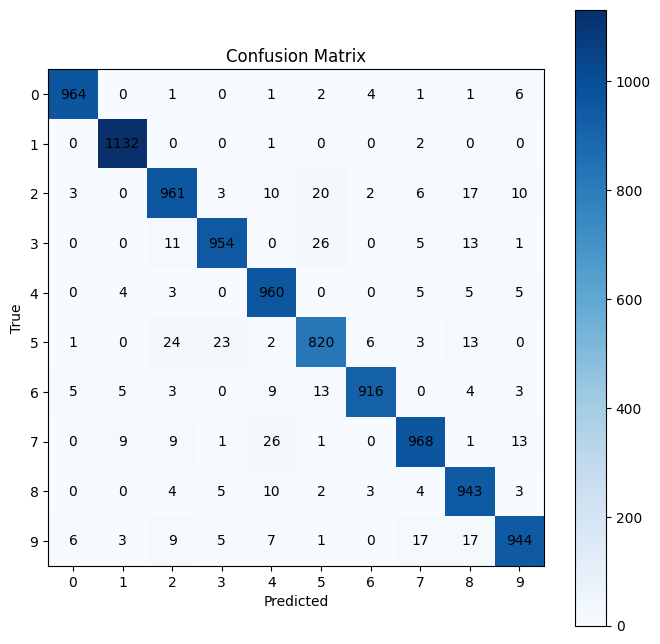

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.94      0.93      0.93      1032
           3       0.96      0.94      0.95      1010
           4       0.94      0.98      0.96       982
           5       0.93      0.92      0.92       892
           6       0.98      0.96      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.97      0.95       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from IPython.display import display, HTML

# Resize and convert grayscale images to RGB
def preprocess_images(images, size=(32, 32)):
    images_rgb = np.zeros((images.shape[0], size[0], size[1], 3))
    for i in range(images.shape[0]):
        img_rgb = np.stack([images[i][:, :, 0]] * 3, axis=-1)
        img_rgb = cv2.resize(img_rgb, size)
        images_rgb[i] = img_rgb
    return images_rgb / 255.0

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images_processed = preprocess_images(np.expand_dims(train_images, axis=-1))
test_images_processed = preprocess_images(np.expand_dims(test_images, axis=-1))
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the convolutional layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model using the VGG16 base and add custom top layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes for digits 0 to 9
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images_processed, train_labels, epochs=1, batch_size=32, validation_data=(test_images_processed, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images_processed, test_labels)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Predict digits and show confusion matrix
predicted_labels = model.predict(test_images_processed).argmax(axis=1)
true_labels = np.argmax(test_labels, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.show()

# Display classification report
print(classification_report(true_labels, predicted_labels))

# Resize and convert grayscale images to RGB for drawing
def preprocess_drawn_image(img, size=(28, 28)):
    img_rgb = cv2.resize(img, size)
    img_rgb = np.stack([img_rgb] * 3, axis=-1)
    return img_rgb.reshape(1, size[0], size[1], 3) / 255.0

# Function to draw a number and recognize it
def draw_and_recognize(model):
    # Create an HTML element to embed the drawing canvas
    html = """
    <canvas id="canvas" width="200" height="200" style="border:1px solid #000;"></canvas>
    <br/>
    <button onclick="clearCanvas()">Clear Canvas</button>
    <button onclick="predictDigit()">Predict Digit</button>
    <script>
  var canvas = document.getElementById('canvas');
  var ctx = canvas.getContext('2d');
  var mousePressed = false;

  canvas.addEventListener('mousedown', function (e) {
    mousePressed = true;
    draw(e.pageX - canvas.offsetLeft, e.pageY - canvas.offsetTop, false);
  });

  canvas.addEventListener('mousemove', function (e) {
    if (mousePressed) {
      draw(e.pageX - canvas.offsetLeft, e.pageY - canvas.offsetTop, true);
    }
  });

  canvas.addEventListener('mouseup', function () {
    mousePressed = false;
  });

  canvas.addEventListener('mouseleave', function () {
    mousePressed = false;
  });

  function draw(x, y, isDown) {
    if (isDown) {
      ctx.beginPath();
      ctx.arc(x, y, 5, 0, 2 * Math.PI);
      ctx.fillStyle = 'black';
      ctx.fill();
      ctx.closePath();
    }
  }

  function clearCanvas() {
    ctx.clearRect(0, 0, canvas.width, canvas.height);
  }

  function predictDigit() {
    var imgData = canvas.toDataURL();
    var img = new Image();
    img.src = imgData;
    img.onload = function () {
      var canvasElement = document.createElement('canvas');
      canvasElement.width = 28;
      canvasElement.height = 28;
      var context = canvasElement.getContext('2d');
      context.drawImage(img, 0, 0, 28, 28);

      // Convert image to grayscale
      var imageData = context.getImageData(0, 0, 28, 28).data;
      var inputArray = [];

      for (var i = 0; i < imageData.length; i += 4) {
        var grayscaleValue = (imageData[i] + imageData[i + 1] + imageData[i + 2]) / 3;
        inputArray.push(grayscaleValue / 255.0);
      }

      // Reshape inputArray to (1, 28, 28, 1)
      var reshapedInput = tf.tensor(inputArray).reshape([1, 28, 28, 1]);

      // Make predictions
      model.predict(reshapedInput).data().then(function(predictions) {
        // Convert predictions to class label
        var predictedLabel = predictions.indexOf(Math.max.apply(null, predictions));

        // Display the drawn image and predicted label
        var resultElement = document.createElement('div');
        resultElement.innerHTML = '<img src="' + imgData + '" style="margin-top: 10px;"/>'
          + '<p>Predicted Label: ' + predictedLabel + '</p>';
        document.body.appendChild(resultElement);
      });
    };
  }
</script>
    """

    # Display the HTML element
    display(HTML(html))

# Call the function with your trained model
draw_and_recognize(model)

# Save the entire model to an HDF5 file
model.save('digit_recognition_model.keras')


In [6]:
import os
print(os.getcwd())


/content
